## Referencias

* https://www.ufrgs.br/wiki-r/index.php?title=Data_Frame

In [ ]:
#install.packages("dplyr")
library(dplyr)
library(rgl)

In [3]:
# Adicionando o diretorio atual
setwd("../");

In [26]:
dataset <- read.csv(file="./summer-products-with-rating-and-performance_2020-08.csv", header=TRUE, sep=",")
dataset <- as.data.frame(dataset)

In [112]:
base <- select(dataset, price, units_sold, rating, rating_count, retail_price)

In [6]:
cor(base)

,price,units_sold,rating,rating_count,retail_price
price,1.000000000,-0.02481474,0.05346852,-0.001910505,0.30474760
units_sold,-0.024814738,1.00000000,0.03947825,0.899463652,0.01263839
rating,0.053468521,0.03947825,1.00000000,0.054112293,0.02410629
rating_count,-0.001910505,0.89946365,0.05411229,1.000000000,0.05387161
retail_price,0.304747605,0.01263839,0.02410629,0.053871605,1.00000000


In [7]:
modelo1var <- lm(base$units_sold ~ base$price)
summary(modelo1var)


Call:
lm(formula = base$units_sold ~ base$price)

Residuals:
   Min     1Q Median     3Q    Max 
 -4722  -4258  -3417    701  95642 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4830.60     552.56   8.742   <2e-16 ***
base$price    -59.05      60.02  -0.984    0.325    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9357 on 1571 degrees of freedom
Multiple R-squared:  0.0006158,	Adjusted R-squared:  -2.037e-05 
F-statistic: 0.968 on 1 and 1571 DF,  p-value: 0.3253


In [8]:
anova(modelo1var)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
base$price,1,84742724,84742724,0.9679726,0.3253378
Residuals,1571,137535726438,87546611,NA,NA


In [222]:
as.numeric(rownames(base$price))
#baseMod = subset(base, base$price<200 & 0 < base$units_sold & base$units_sold < 200)
baseMod = base

numeric(0)

In [191]:
applylmgraph = function(xval, yval, xlab="X", ylab="Y")
{
    modelo2var <- lm(yval ~ xval)
    fitline <- predict(modelo2var);
    lin0 = c(min(xval), max(xval))
    lin1 = c(min(fitline), max(fitline));
    print(lin0)
    plot(x=xval, y=yval, ylab=ylab, xlab=xlab);
    lines(x = lin0, y = lin1, col = "red");
}

[1] 0.000000 1.690196
     price
1    16.00
2     8.00
3     8.00
4     8.00
5     2.72
6     3.92
7     7.00
8    12.00
9    11.00
10    5.78
11    5.79
12    6.00
13    1.91
14    5.79
15    2.00
16   11.00
17   11.00
18    5.00
19    9.00
20    7.00
21   11.00
22    5.00
23   11.00
24    7.00
25    5.71
26    9.00
27    9.00
28    5.65
29    1.74
30    5.65
31   14.00
32    5.65
33    8.00
34    2.66
35    9.00
36   11.00
37    8.00
38   14.00
39    5.80
40   13.00
41    9.00
42    7.00
43   12.00
44    3.69
45    5.00
46    5.84
47   16.00
48   13.00
49    9.00
50    7.00
51   11.00
52    5.84
53    1.00
54   11.00
55    9.00
56    6.00
57    1.00
58    9.00
59    6.00
60   11.00
61    7.00
62    5.00
63    2.72
64    5.87
65   11.00
66    8.00
67   14.00
68    2.00
69    8.00
70    5.79
71    8.00
72    4.94
73    8.00
74   11.00
75    8.00
76    9.00
77    7.00
78   11.00
79    8.00
80    5.83
81    8.00
82    5.77
83    5.90
84    6.00
85    7.00
86    8.00
87   12.00
88    5.78

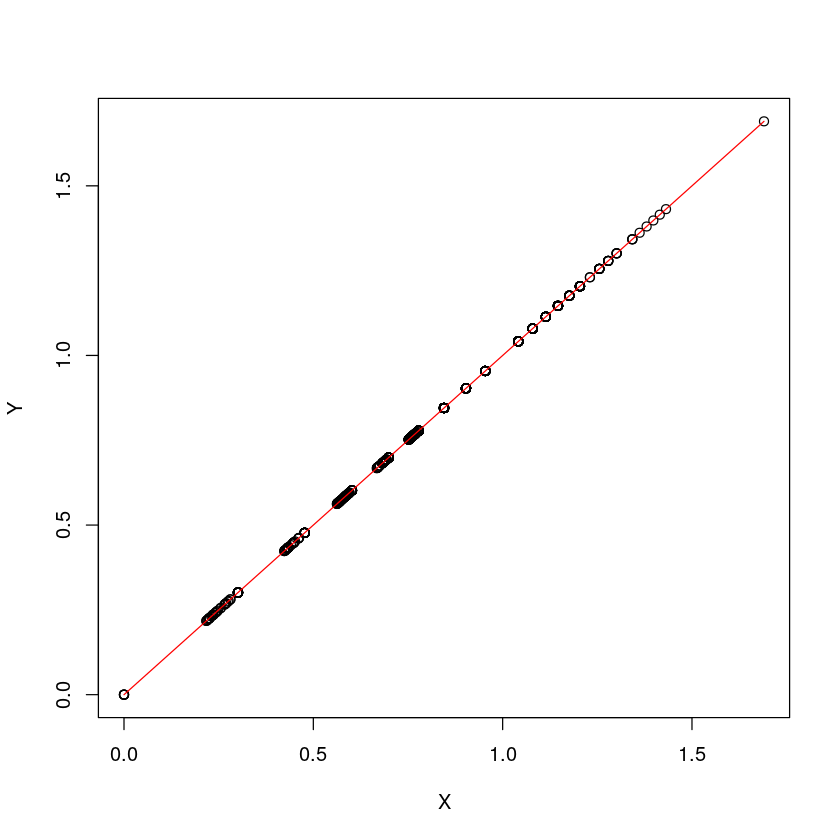

In [263]:
logap = function(x){log(x, 10)}

# Valores de teste, pra garantir que ta safe a funcao 
#vals = 1:10
#obs  = c(3, 4, 7, 6, 9, 10, 14, 7, 15, 19)
#applylmgraph(obs, vals)

applylmgraph(t(as.data.frame(lapply(baseMod$price, logap))), t(as.data.frame(lapply(baseMod$price, logap))))
#applylmgraph(baseMod$price, baseMod$units_sold)
#applylmgraph(baseMod$retail_price, baseMod$rating)


for(i in (1: ncol(base)))
{
    for(j in (1: ncol(base)))
        
}



Call:
lm(formula = base$units_sold ~ base$price)

Residuals:
   Min     1Q Median     3Q    Max 
 -4722  -4258  -3417    701  95642 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4830.60     552.56   8.742   <2e-16 ***
base$price    -59.05      60.02  -0.984    0.325    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9357 on 1571 degrees of freedom
Multiple R-squared:  0.0006158,	Adjusted R-squared:  -2.037e-05 
F-statistic: 0.968 on 1 and 1571 DF,  p-value: 0.3253


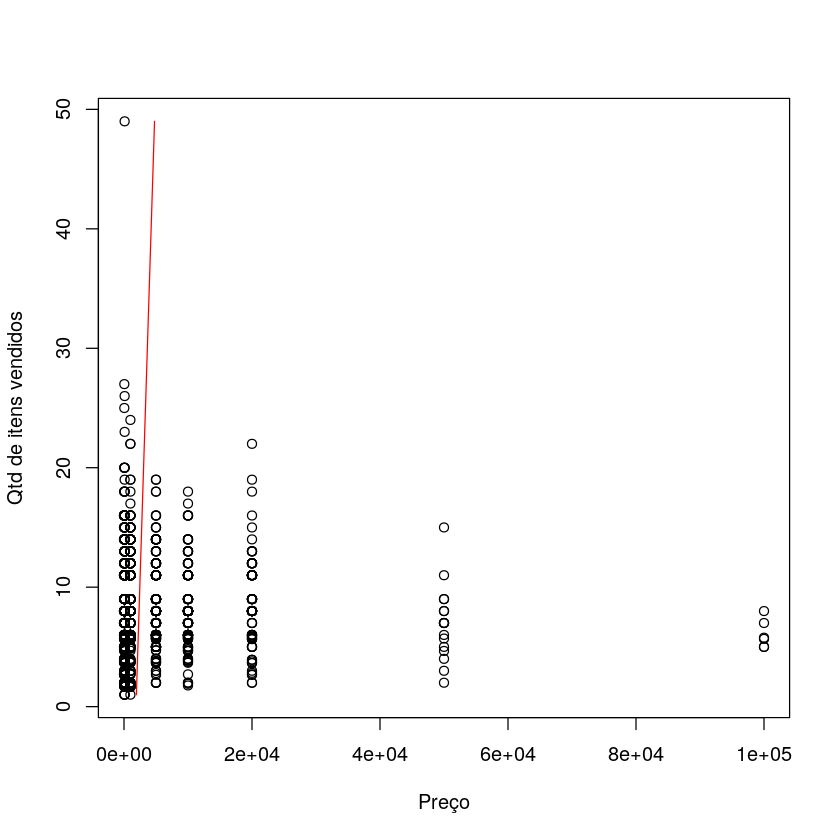

In [122]:
modelo2var <- lm(base$units_sold ~ base$price)
summary(modelo2var)

fitline <- predict(modelo2var)

lin0 = c(min(base$price), max(base$price))
lin1 = c(min(fitline), max(fitline));
plot(y=base$price, x=base$units_sold, ylab="Qtd de itens vendidos", xlab="Preço");
lines(y = lin0, x = lin1, col = "red");

In [10]:
modelo2var <- lm(base$units_sold ~ base$price + base$rating)
summary(modelo2var)


Call:
lm(formula = base$units_sold ~ base$price + base$rating)

Residuals:
   Min     1Q Median     3Q    Max 
 -5574  -4102  -3376    744  95706 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)  2035.28    1810.73   1.124    0.261
base$price    -64.25      60.07  -1.070    0.285
base$rating   742.93     458.32   1.621    0.105

Residual standard error: 9352 on 1570 degrees of freedom
Multiple R-squared:  0.002286,	Adjusted R-squared:  0.001015 
F-statistic: 1.798 on 2 and 1570 DF,  p-value: 0.1659
